# Generating Synthetic MMM Data

Before trusting a Media Mix Model (MMM) on real business data, we need confidence that it can actually recover the parameters that generated the observations. **Parameter recovery** is the gold-standard validation technique: we generate synthetic data from known ground-truth values, fit the model back on that data, and check whether the posteriors concentrate around the true values.

This notebook walks through the full parameter recovery workflow:

1. **Generate correlated channel spend covariates** using a multivariate normal model with an LKJ prior on the correlation structure.
2. **Fix known "true" parameter values** for adstock, saturation, seasonality, and noise.
3. **Forward-sample through the MMM** using PyMC's `do` operator to produce a synthetic observed target variable.
4. **Fit the MMM** on the synthetic data using the same model specification.
5. **Verify recovery** by comparing posterior distributions against the ground-truth values.

We use `pymc-marketing`'s `MMM` class with `GeometricAdstock` and `LogisticSaturation` transformations, and rely on PyMC's `do` operator for causal intervention (clamping parameters to their true values during data generation).

## Prepare Notebook

We load the required libraries and configure plotting defaults. The `autoreload` magic is enabled for development convenience so that changes to `pymc_marketing` source code are picked up automatically.

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt
import seaborn as sns
from pymc import do
from pymc_extras.prior import Prior

from pymc_marketing.mmm import GeometricAdstock, LogisticSaturation
from pymc_marketing.mmm.multidimensional import MMM

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [2]:
seed: int = sum(map(ord, "mmm"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

We fix a random seed derived from `sum(map(ord, "mmm"))` and use `np.random.default_rng` throughout the notebook to ensure full reproducibility of all random draws.

## Generating Covariates Data

The first step is to generate realistic media channel spend data. Real-world channel spends are typically correlated (e.g., brands may increase spend across multiple channels simultaneously during campaigns) and exhibit trends over time. We model this with a PyMC generative model that captures both properties.

**Configuration parameters:**

- `n_dates = 120` weekly observations (~2.3 years of data).
- `n_channels = 5` media channels.
- `l_max = 6` maximum adstock lag (weeks).
- `n_fourier_modes = 3` pairs of Fourier terms for yearly seasonality.
- `chol_eta = 3` concentration parameter for the LKJ Cholesky prior on channel correlations (higher values push toward less correlation).

In [3]:
# Configuration Parameters

n_dates = 120

date_range = pd.date_range(start="2020-01-01", freq="W-MON", periods=n_dates)


n_channels = 5

l_max = 6

n_fourier_modes = 3

chol_eta = 3

coords = {"channel": [f"x{i}" for i in range(n_channels)], "date": date_range}

**Generative model for covariates:**

We build a PyMC model where each channel's spend at each time step is drawn from a multivariate normal distribution:

- **Time normalization**: `t` is scaled to $[0, 1)$ so the linear trend coefficients are on a comparable scale.
- **LKJ Cholesky prior** (`LKJCholeskyCov`): Induces a realistic correlation structure across channels. The Cholesky factor `L` is used directly in the `MvNormal` likelihood for numerical stability.
- **Linear trends**: Each channel gets its own intercept `a` and slope `b`, so channels can have different baseline levels and growth/decline trajectories over time.
- **Multivariate normal draws**: At each time step the 5-dimensional channel vector is drawn from `MvNormal(mu, chol=L)`, ensuring cross-channel correlations.
- **Softplus transformation**: `softplus(x) = log(1 + exp(x))` ensures all spend values are non-negative, which is a hard constraint for media spend data.

We visualize the resulting directed acyclic graph (DAG) with `pm.model_to_graphviz`.

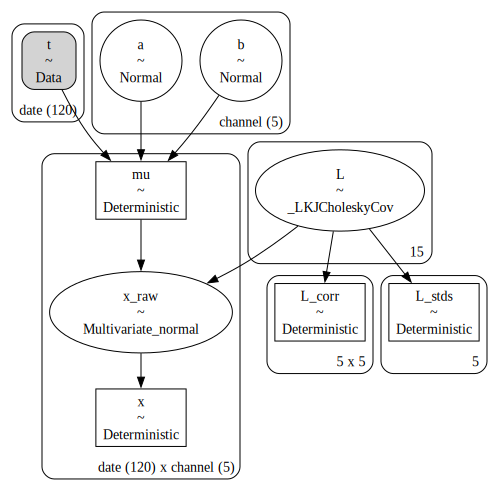

In [4]:
t = np.arange(n_dates) / n_dates

with pm.Model(coords=coords) as covariates_model:
    t_data = pm.Data("t", t, dims=("date",))

    L, _, _ = pm.LKJCholeskyCov(
        "L",
        n=len(coords["channel"]),
        eta=chol_eta,
        sd_dist=pm.Exponential.dist(lam=1 / 3),
    )

    a = pm.Normal("a", mu=0, sigma=1, dims="channel")
    b = pm.Normal("b", mu=0, sigma=1, dims="channel")

    mu = pm.Deterministic("mu", a + b * t_data[..., None], dims=("date", "channel"))

    x_raw = pm.MvNormal("x_raw", mu=mu, chol=L, dims=("date", "channel"))

    x = pm.Deterministic("x", pt.softplus(x_raw), dims=("date", "channel"))

pm.model_to_graphviz(covariates_model)

We draw a single realization from the covariates model and assemble it into a pandas DataFrame. A dummy target column `y_dummy = 1` is added as a placeholder; it will be replaced later with the actual synthetic observations.

In [5]:
x_data = pm.draw(covariates_model.x, draws=1, random_seed=rng)

mmm_df = pd.DataFrame(x_data, columns=coords["channel"]).assign(
    date=date_range, y_dummy=np.ones(n_dates)
)

col = mmm_df.pop("date")
mmm_df.insert(0, "date", col)

mmm_df.head()

,date,x0,x1,x2,x3,x4,y_dummy
0,2020-01-06,6.208217,1.239197,0.455048,3.493189,0.997002,1.0
1,2020-01-13,3.640003,0.096297,0.744953,0.366538,2.316299,1.0
2,2020-01-20,5.412316,0.012111,0.133368,5.640305,2.368558,1.0
3,2020-01-27,0.167504,0.689889,1.906349,0.278028,0.518104,1.0
4,2020-02-03,0.025429,0.289182,0.750129,0.013511,1.466233,1.0


## Specify Model Configuration

This cell serves two purposes:

1. **Draw ground-truth parameter values** from specific prior distributions. These are the "true" values we will try to recover later.
2. **Define the `model_config` dictionary** that parameterizes the MMM using the same prior families.

The ground-truth parameters and their roles:

| Parameter | Distribution | Role |
|---|---|---|
| `intercept_true` | $\text{Normal}(0, 2)$ | Baseline sales level |
| `adstock_alpha_true` | $\text{Beta}(1, 3)$ | Geometric adstock decay rates (favors faster decay) |
| `saturation_beta_true` | $\text{HalfNormal}(2)$ | Channel effect magnitudes |
| `saturation_lam_true` | $\text{Gamma}(2, 1)$ | Saturation curve steepness |
| `gamma_fourier_true` | $\text{Laplace}(0, 0.2)$ | Yearly seasonality Fourier coefficients (sparse) |
| `y_sigma_true` | $\text{HalfNormal}(3)$ | Observation noise scale |

Using the **same prior family** for generating truth and for inference is the cleanest setup for a parameter recovery test: it isolates the question of whether the model structure and sampler can recover the parameters, without confounding from prior-data conflict.

We then instantiate an `MMM` object (the "generator") with `GeometricAdstock` and `LogisticSaturation` transformations and `n_fourier_modes` Fourier pairs for yearly seasonality.

In [6]:
intercept_true = pm.draw(pm.Normal.dist(sigma=2), draws=1, random_seed=rng)
adstock_alpha_true = pm.draw(
    pm.Beta.dist(alpha=1, beta=3), draws=len(coords["channel"]), random_seed=rng
)
saturation_beta_true = pm.draw(
    pm.HalfNormal.dist(sigma=2), draws=len(coords["channel"]), random_seed=rng
)
saturation_lam_true = pm.draw(
    pm.Gamma.dist(alpha=2, beta=1), draws=len(coords["channel"]), random_seed=rng
)
gamma_fourier_true = pm.draw(
    pm.Laplace.dist(mu=0, b=0.2, size=2 * n_fourier_modes), random_seed=rng
)
y_sigma_true = pm.draw(pm.HalfNormal.dist(sigma=3), draws=1, random_seed=rng)


model_config = {
    "intercept": Prior("Normal", mu=0, sigma=2),
    "adstock_alpha": Prior("Beta", alpha=1, beta=3, dims="channel"),
    "saturation_beta": Prior("HalfNormal", sigma=2, dims="channel"),
    "saturation_lam": Prior("Gamma", alpha=2, beta=1, dims="channel"),
    "gamma_control": Prior("Normal", mu=0, sigma=1, dims="control"),
    "gamma_fourier": Prior("Laplace", mu=0, b=0.2, dims="fourier_mode"),
    "likelihood": Prior("Normal", sigma=Prior("HalfNormal", sigma=3)),
}

mmm_generator = MMM(
    date_column="date",
    target_column="y_dummy",
    channel_columns=coords["channel"],
    adstock=GeometricAdstock(l_max=l_max),
    saturation=LogisticSaturation(),
    yearly_seasonality=n_fourier_modes,
    model_config=model_config,
)

## Generate Target Variable

Now we use the MMM's generative structure to produce synthetic observations. The strategy is a **forward simulation** through the model graph with the parameters clamped to their known true values:

1. **Build the model graph**: `mmm_generator.build_model(X, y_dummy)` compiles the full MMM computation graph. We also register original-scale contribution variables (before target scaling) so we can inspect the true decomposition later.
2. **Intervene with `do`**: PyMC's `do` operator clamps stochastic nodes to their ground-truth values. This turns the probabilistic model into a deterministic forward simulator (aside from observation noise $\sigma$), ensuring the synthetic data is generated from *exactly* the parameter values we want to recover.
3. **Sample forward**: `pm.sample_prior_predictive(draws=1)` propagates the clamped values through the adstock, saturation, and seasonality transformations to produce one synthetic target time series.
4. **Assemble final data**: The synthetic `y_obs` replaces the dummy target. We drop the first `l_max` rows because the geometric adstock transformation needs a burn-in window to avoid edge effects.

In [7]:
X = mmm_df.drop(columns=["y_dummy"])
y_dummy = mmm_df["y_dummy"]

mmm_generator.build_model(X, y_dummy)
mmm_generator.add_original_scale_contribution_variable(
    var=[
        "channel_contribution",
        "intercept_contribution",
        "yearly_seasonality_contribution",
        "y",
    ]
)

In [8]:
mmm_generator.model = do(
    mmm_generator.model,
    {
        "intercept_contribution": intercept_true,
        "adstock_alpha": adstock_alpha_true,
        "saturation_beta": saturation_beta_true,
        "saturation_lam": saturation_lam_true,
        "gamma_fourier": gamma_fourier_true,
        "y_sigma": y_sigma_true,
    },
)

In [9]:
with mmm_generator.model:
    idata_obs = pm.sample_prior_predictive(
        draws=1,
        var_names=[
            "y",
            "y_original_scale",
            "channel_contribution_original_scale",
        ],
        random_seed=rng,
    )

Sampling: [y]


In [10]:
y_obs = idata_obs["prior"]["y_original_scale"].sel(chain=0, draw=0)

mmm_df["y_obs"] = y_obs

# Remove last dates (adstock lag)
mmm_df = mmm_df.tail(-l_max)
coords["date"] = coords["date"][l_max:]

mmm_df.head()

,date,x0,x1,x2,x3,x4,y_dummy,y_obs
6,2020-02-17,4.364082,1.958480,1.873190,0.005611,0.804895,1.0,2.381511
7,2020-02-24,0.735180,1.442319,0.682221,5.882805,0.572488,1.0,0.886471
8,2020-03-02,7.069741,0.560737,0.417488,0.001453,0.217027,1.0,0.855292
9,2020-03-09,0.312553,0.208669,0.106582,0.001532,1.392096,1.0,-0.278851
10,2020-03-16,1.582743,0.026846,0.065228,0.025798,1.817333,1.0,-0.255760


### Exploratory Visualizations

Before moving to parameter recovery, we inspect the synthetic data to confirm it looks reasonable:

- **Channel correlation matrix**: Verifies the LKJ prior produced realistic (but not degenerate) cross-channel correlations.
- **Time-series panel plots**: Shows the target variable and each channel's spend over time, letting us visually check for trends and variation.
- **True channel contributions**: Displays the ground-truth decomposition of the target into individual channel effects. These are the benchmark curves we hope to recover during inference.

In [11]:
mmm_df[coords["channel"]].corr()

,x0,x1,x2,x3,x4
x0,1.000000,-0.117607,-0.070978,-0.176938,0.212297
x1,-0.117607,1.000000,0.027311,0.017998,-0.501167
x2,-0.070978,0.027311,1.000000,0.046590,0.039386
x3,-0.176938,0.017998,0.046590,1.000000,0.145880
x4,0.212297,-0.501167,0.039386,0.145880,1.000000


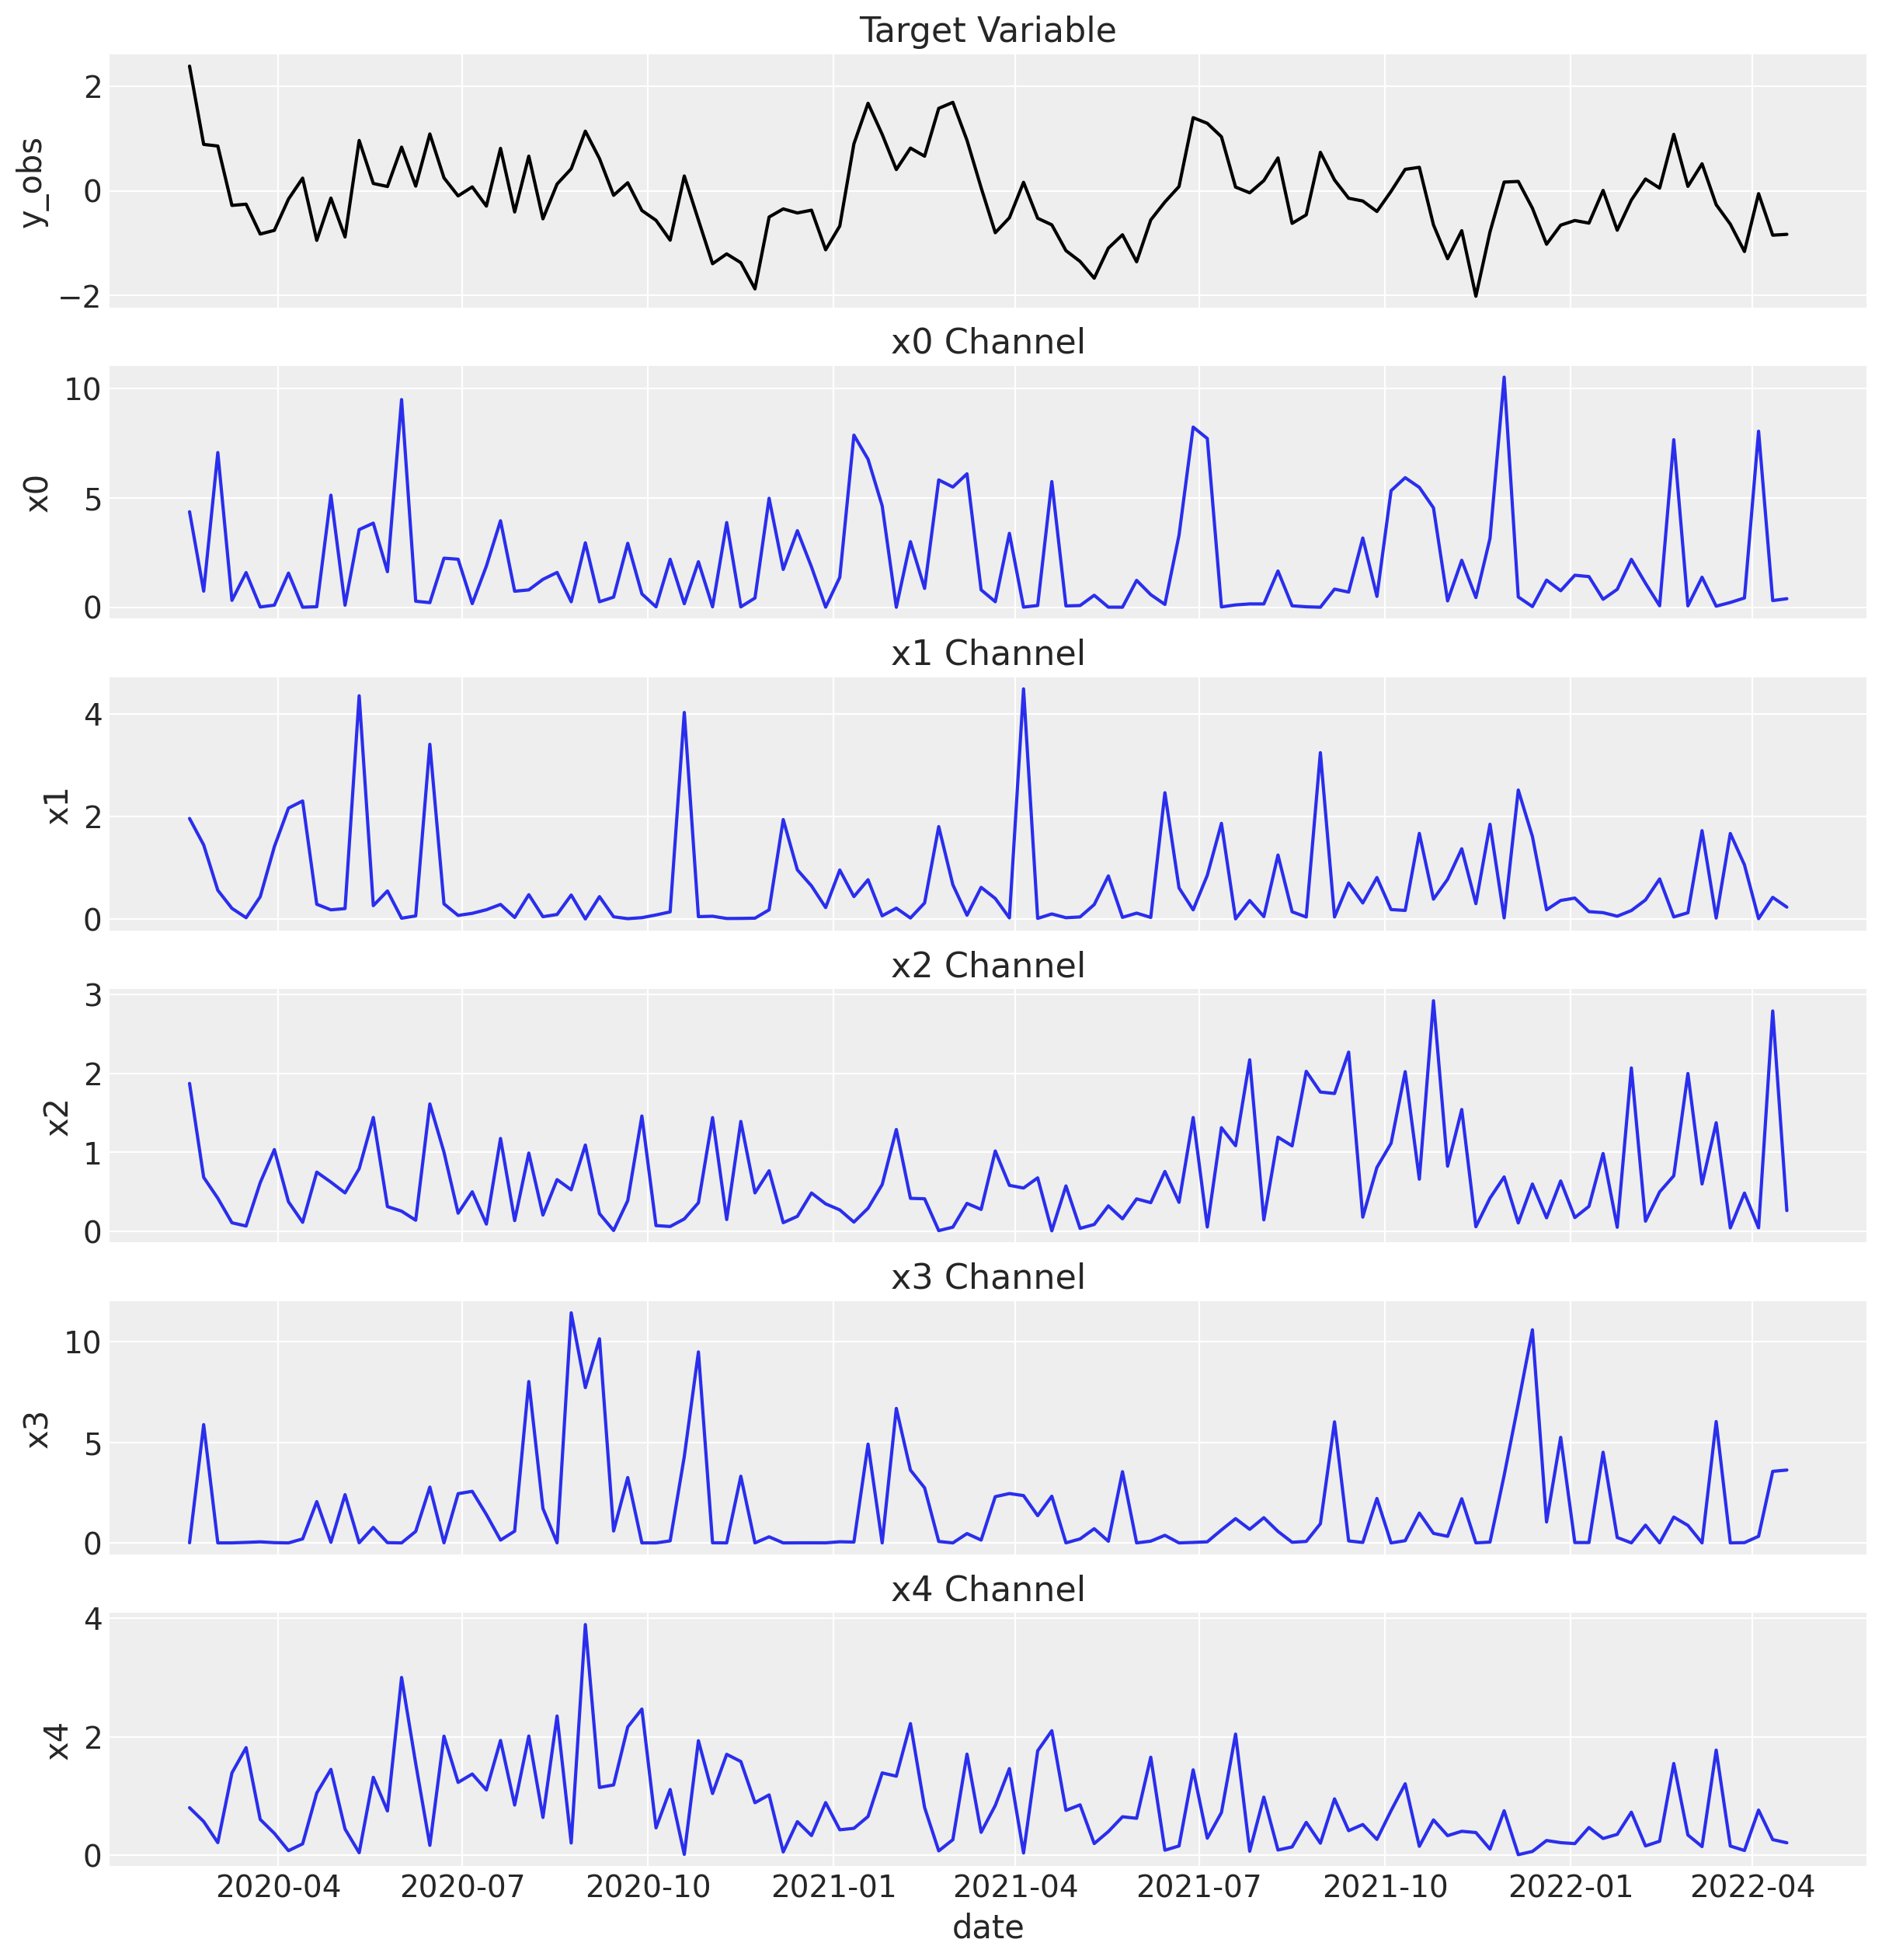

In [12]:
fig, ax = plt.subplots(
    nrows=len(coords["channel"]) + 1,
    figsize=(12, len(coords["channel"]) * 2.5),
    sharex=True,
)

sns.lineplot(x="date", y="y_obs", data=mmm_df, color="black", ax=ax[0])
ax[0].set_title("Target Variable")

for i, channel in enumerate(coords["channel"]):
    sns.lineplot(x="date", y=channel, data=mmm_df, color="C0", ax=ax[i + 1])
    ax[i + 1].set_title(f"{channel} Channel")

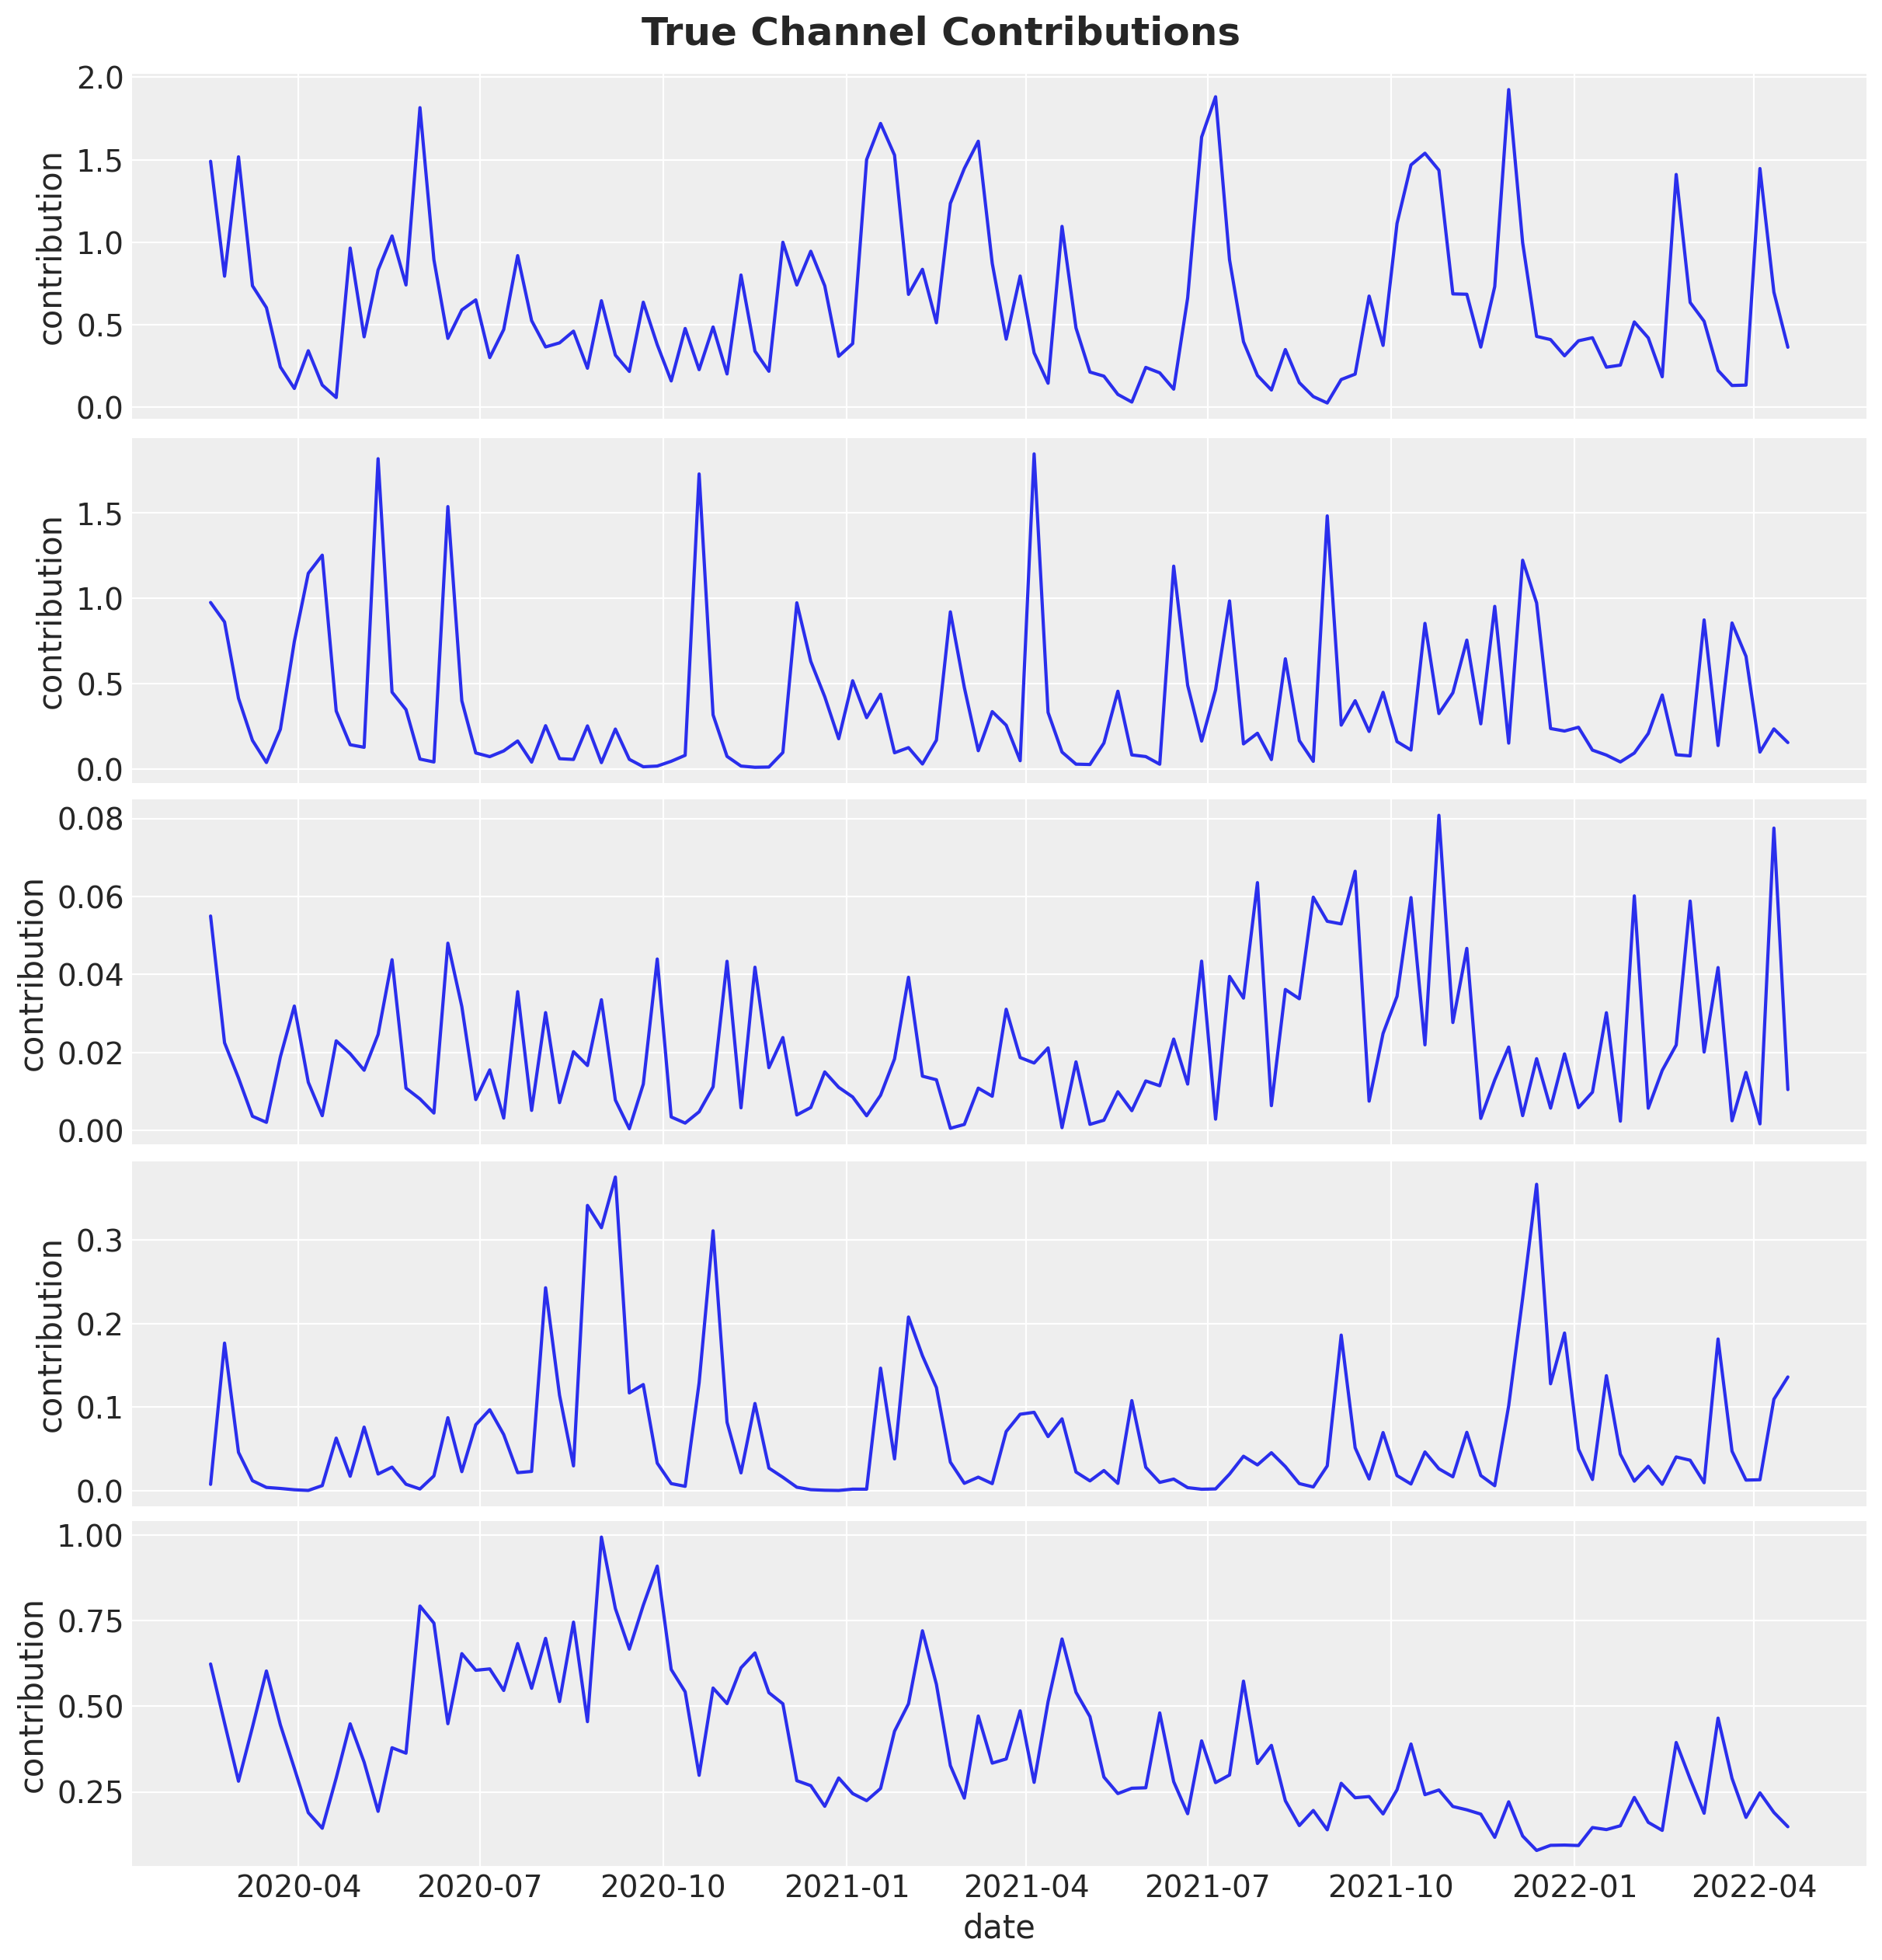

In [13]:
fig, axes = plt.subplots(
    nrows=len(coords["channel"]),
    figsize=(12, len(coords["channel"]) * 2.5),
    sharex=True,
)

for i, channel in enumerate(coords["channel"]):
    channel_contribution_observed = (
        idata_obs["prior"]["channel_contribution_original_scale"]
        .sel(chain=0, draw=0)
        .sel(channel=channel)
        .to_numpy()[l_max:]
    )

    sns.lineplot(
        data=mmm_df, x="date", y=channel_contribution_observed, color="C0", ax=axes[i]
    )

    axes[i].set(ylabel="contribution")

fig.suptitle("True Channel Contributions", fontsize=18, fontweight="bold");

## Parameter Recovery

With the synthetic data in hand, we now fit the MMM and check whether the posteriors recover the true parameter values. This is the core validation step: if the model cannot recover known parameters from clean synthetic data, we should not trust it on noisy real-world data.

### Fit Model

We create a *new* `MMM` instance that targets `y_obs` (the synthetic data) and fit it using MCMC.

**Informative priors via channel shares**: Before fitting, we adjust the `saturation_beta` prior. The sigma of the `HalfNormal` prior is scaled by each channel's share of total spend (`n_channels * channel_shares`), encoding the reasonable belief that channels with more spend are likely to have larger effect magnitudes. This is a common practice that helps the sampler explore more efficiently.

The model structure and all other priors are intentionally **identical** to the data-generating process, making this a fair parameter recovery test. We use the `nutpie` sampler with `target_accept=0.9` for reliable posterior exploration, and also draw posterior predictive samples for visual diagnostics.

In [14]:
channel_shares = (
    mmm_df[coords["channel"]].sum(axis=0) / mmm_df[coords["channel"]].sum(axis=0).sum()
).to_numpy()

prior_sigma = n_channels * channel_shares

In [15]:
model_config["saturation_beta"] = Prior("HalfNormal", sigma=prior_sigma, dims="channel")

mmm = MMM(
    date_column="date",
    target_column="y_obs",
    channel_columns=coords["channel"],
    adstock=GeometricAdstock(l_max=l_max),
    saturation=LogisticSaturation(),
    yearly_seasonality=n_fourier_modes,
    model_config=model_config,
    sampler_config={"nuts_sampler": "nutpie"},
)

X = mmm_df[["date", *coords["channel"]]]
y = mmm_df["y_obs"]

mmm.build_model(X, y)
mmm.add_original_scale_contribution_variable(
    var=[
        "channel_contribution",
        "intercept_contribution",
        "yearly_seasonality_contribution",
        "y",
    ]
)


_ = mmm.fit(
    X,
    y,
    chains=4,
    tune=1_500,
    draws=1_000,
    target_accept=0.9,
    random_seed=rng,
)

_ = mmm.sample_posterior_predictive(X=X, random_seed=rng)

Progress,Draws,Divergences,Step Size,Gradients/Draw
,2500,0,0.16,63
,2500,0,0.18,63
,2500,0,0.17,31
,2500,0,0.16,63


Output()

Sampling: [y]


Output()

### Visualization

We now visually assess whether the model successfully recovered the true parameters and structure of the synthetic data.

**Model Parameters**

We use `az.plot_posterior` with `ref_val` to overlay the true parameter values (vertical reference lines) on the posterior densities. If the reference lines fall within the bulk of each posterior distribution, the parameter recovery is successful.

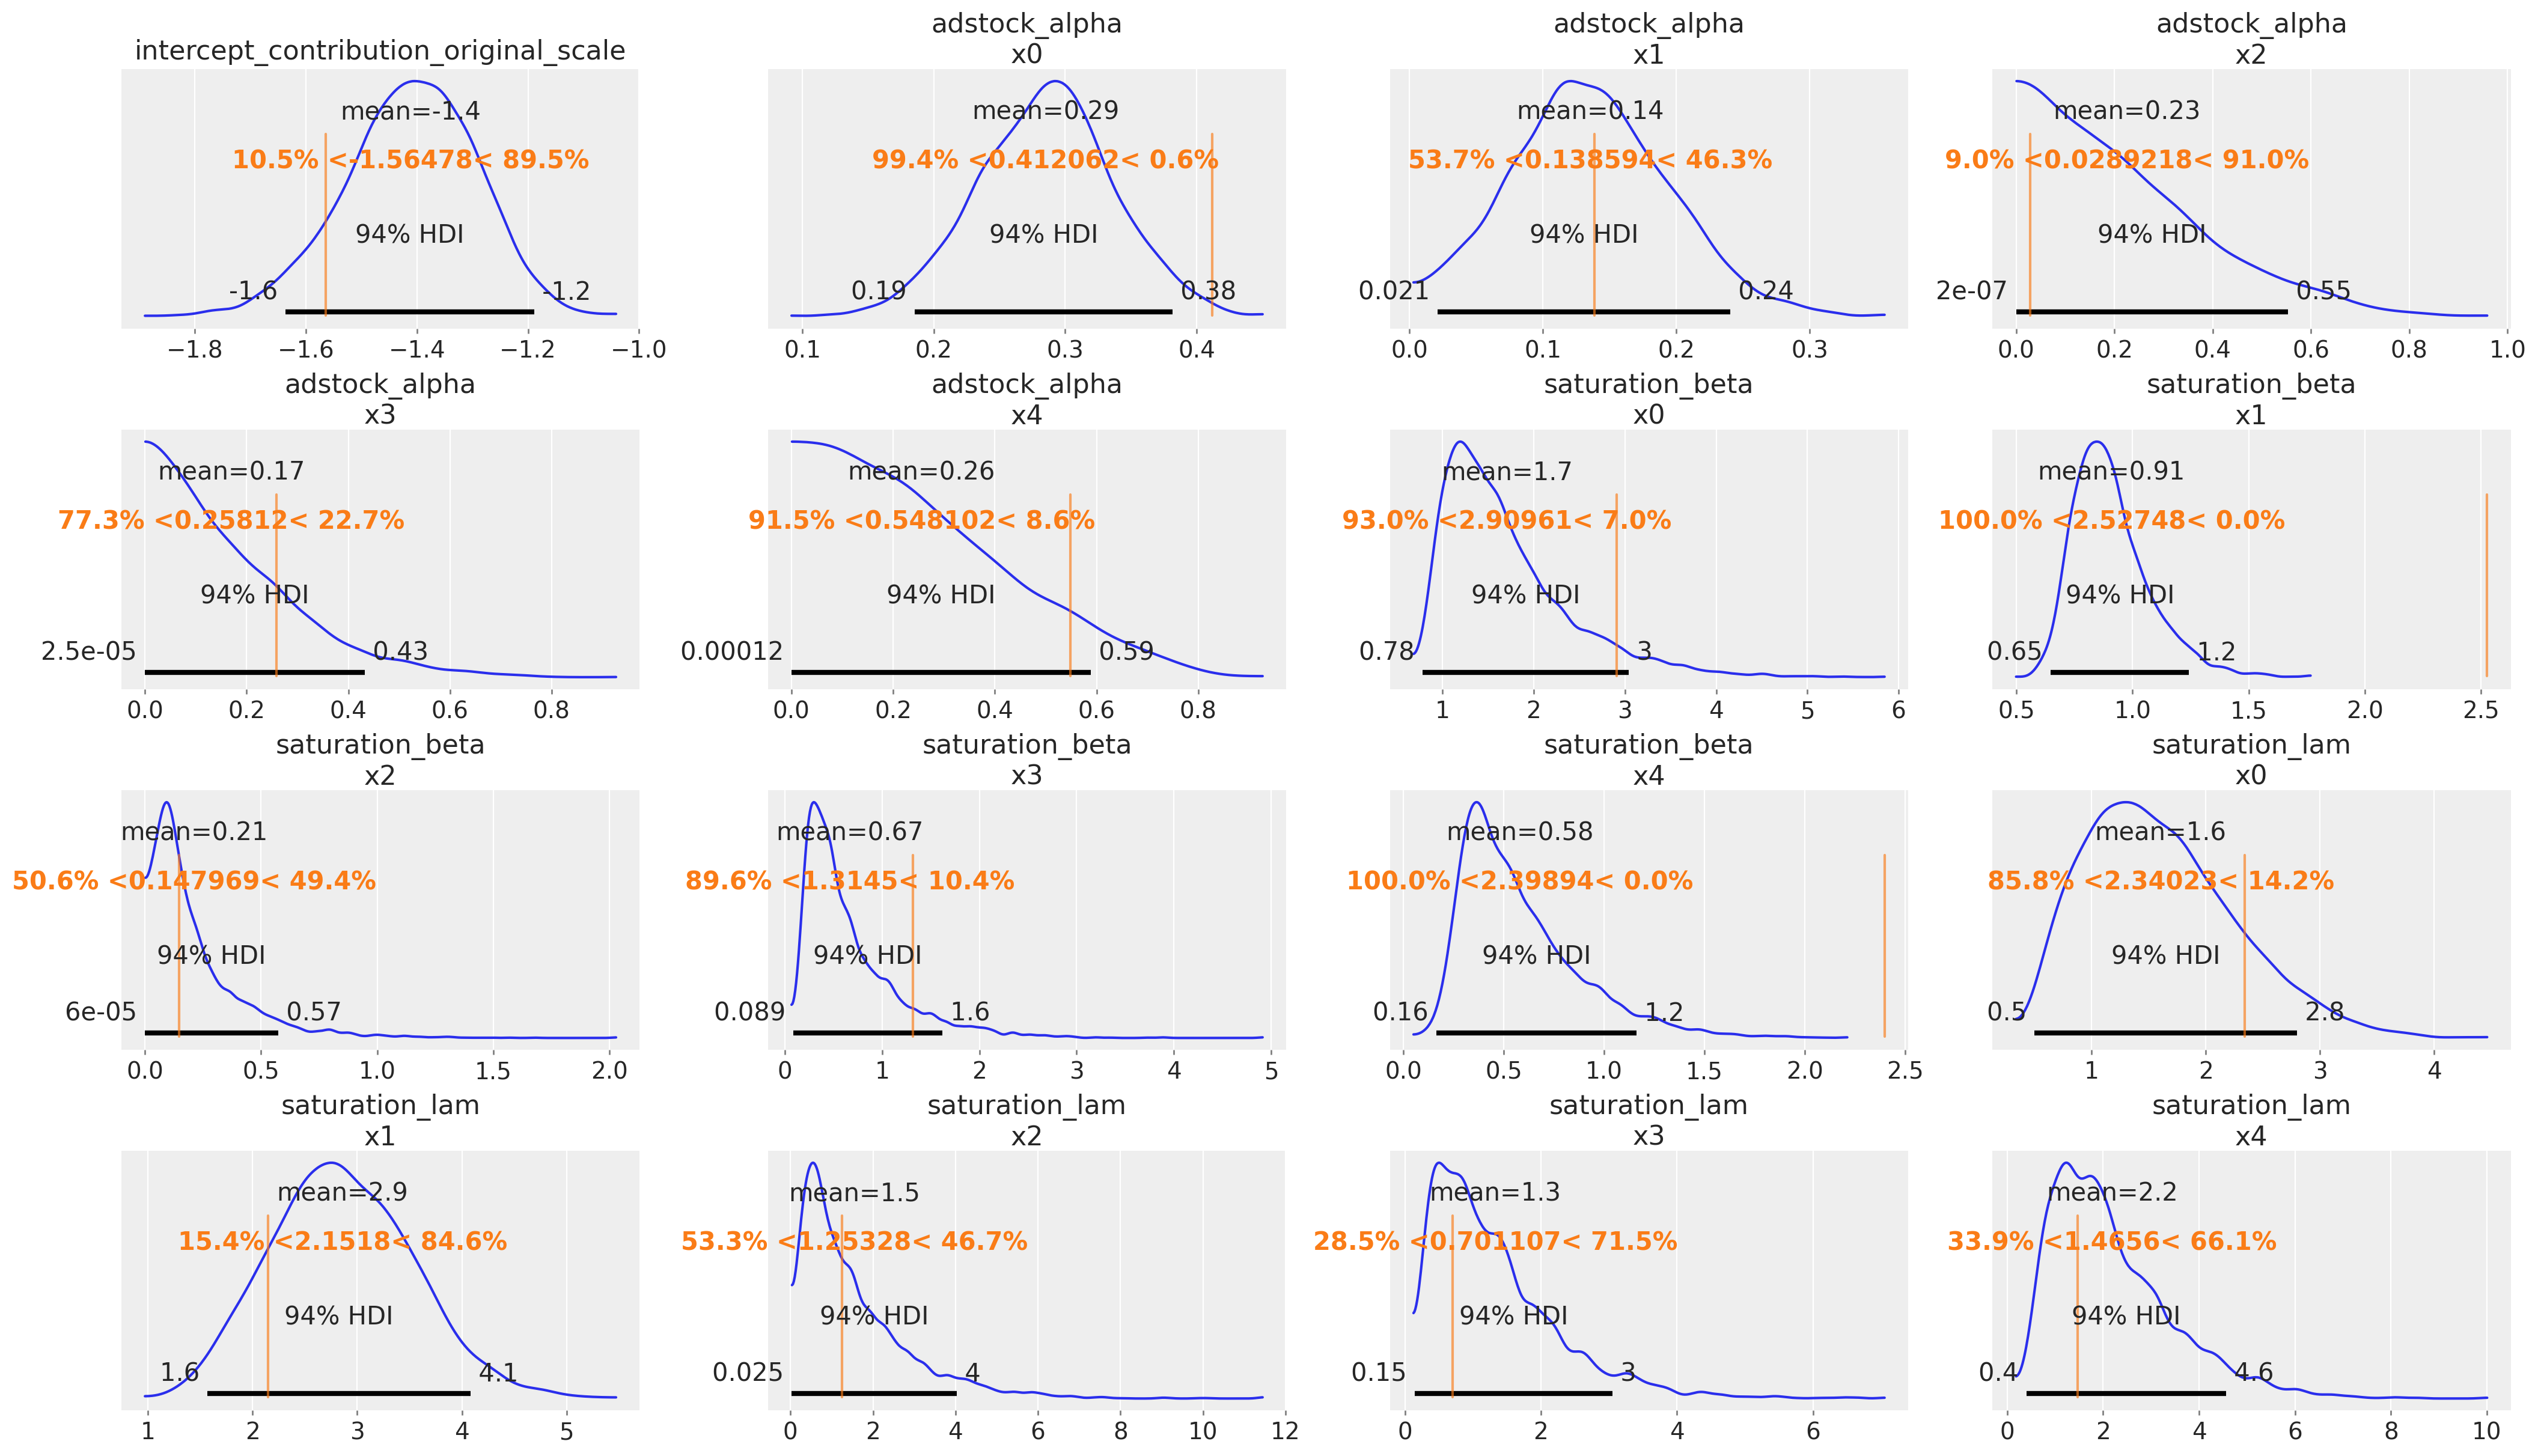

In [16]:
az.plot_posterior(
    mmm.idata,
    var_names=[
        "intercept_contribution_original_scale",
        "adstock_alpha",
        "saturation_beta",
        "saturation_lam",
    ],
    ref_val={
        "intercept_contribution_original_scale": [{"ref_val": intercept_true}],
        "adstock_alpha": [
            {"channel": f"x{i}", "ref_val": adstock_alpha_true[i]}
            for i in range(n_channels)
        ],
        "saturation_beta": [
            {"channel": f"x{i}", "ref_val": saturation_beta_true[i]}
            for i in range(n_channels)
        ],
        "saturation_lam": [
            {"channel": f"x{i}", "ref_val": saturation_lam_true[i]}
            for i in range(n_channels)
        ],
    },
    figsize=(21, 12),
);

**Posterior Predictive**

The posterior predictive distribution should tightly envelop the observed (synthetic) time series. A good fit here confirms the model can reproduce the overall signal, including trends and seasonality.

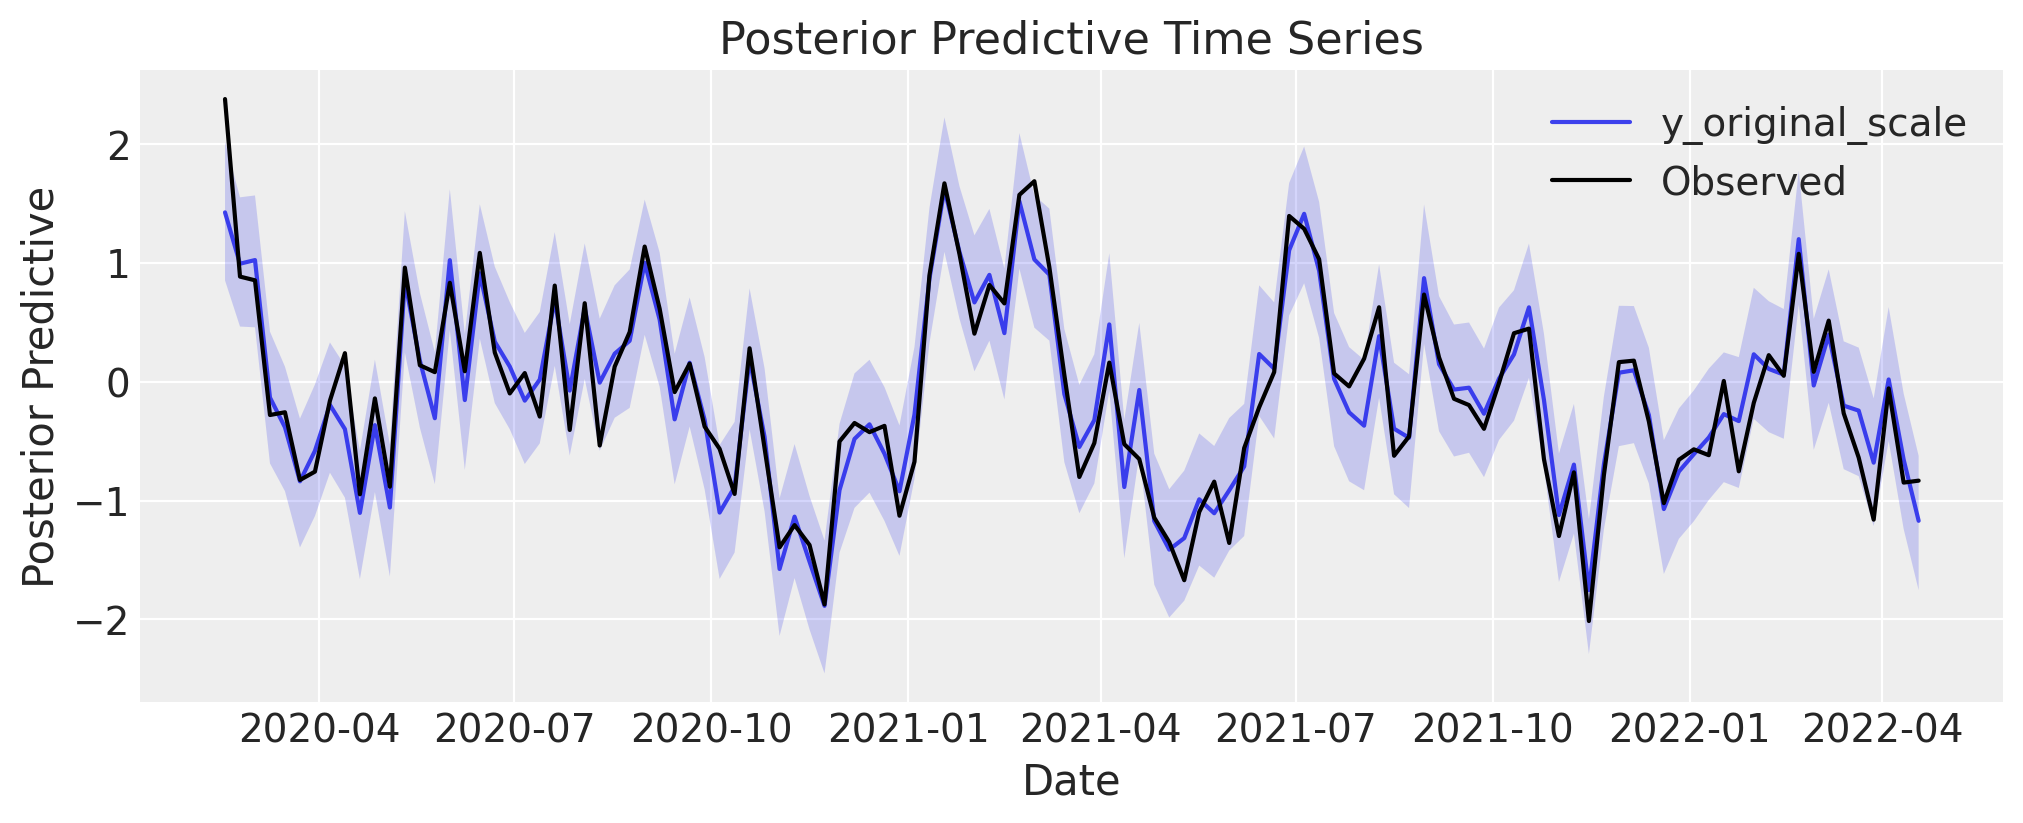

In [ ]:
fig, axes = mmm.plot.posterior_predictive(var=["y_original_scale"], hdi_prob=0.94)
sns.lineplot(
    data=mmm_df, x="date", y="y_obs", color="black", label="Observed", ax=axes[0][0]
);

**Channel Contributions**

We compare the estimated channel contribution curves (with uncertainty bands) against the known true contributions (black lines). Good overlap between the posterior estimates and the ground-truth curves validates that the model correctly decomposes the total target signal into individual channel effects.

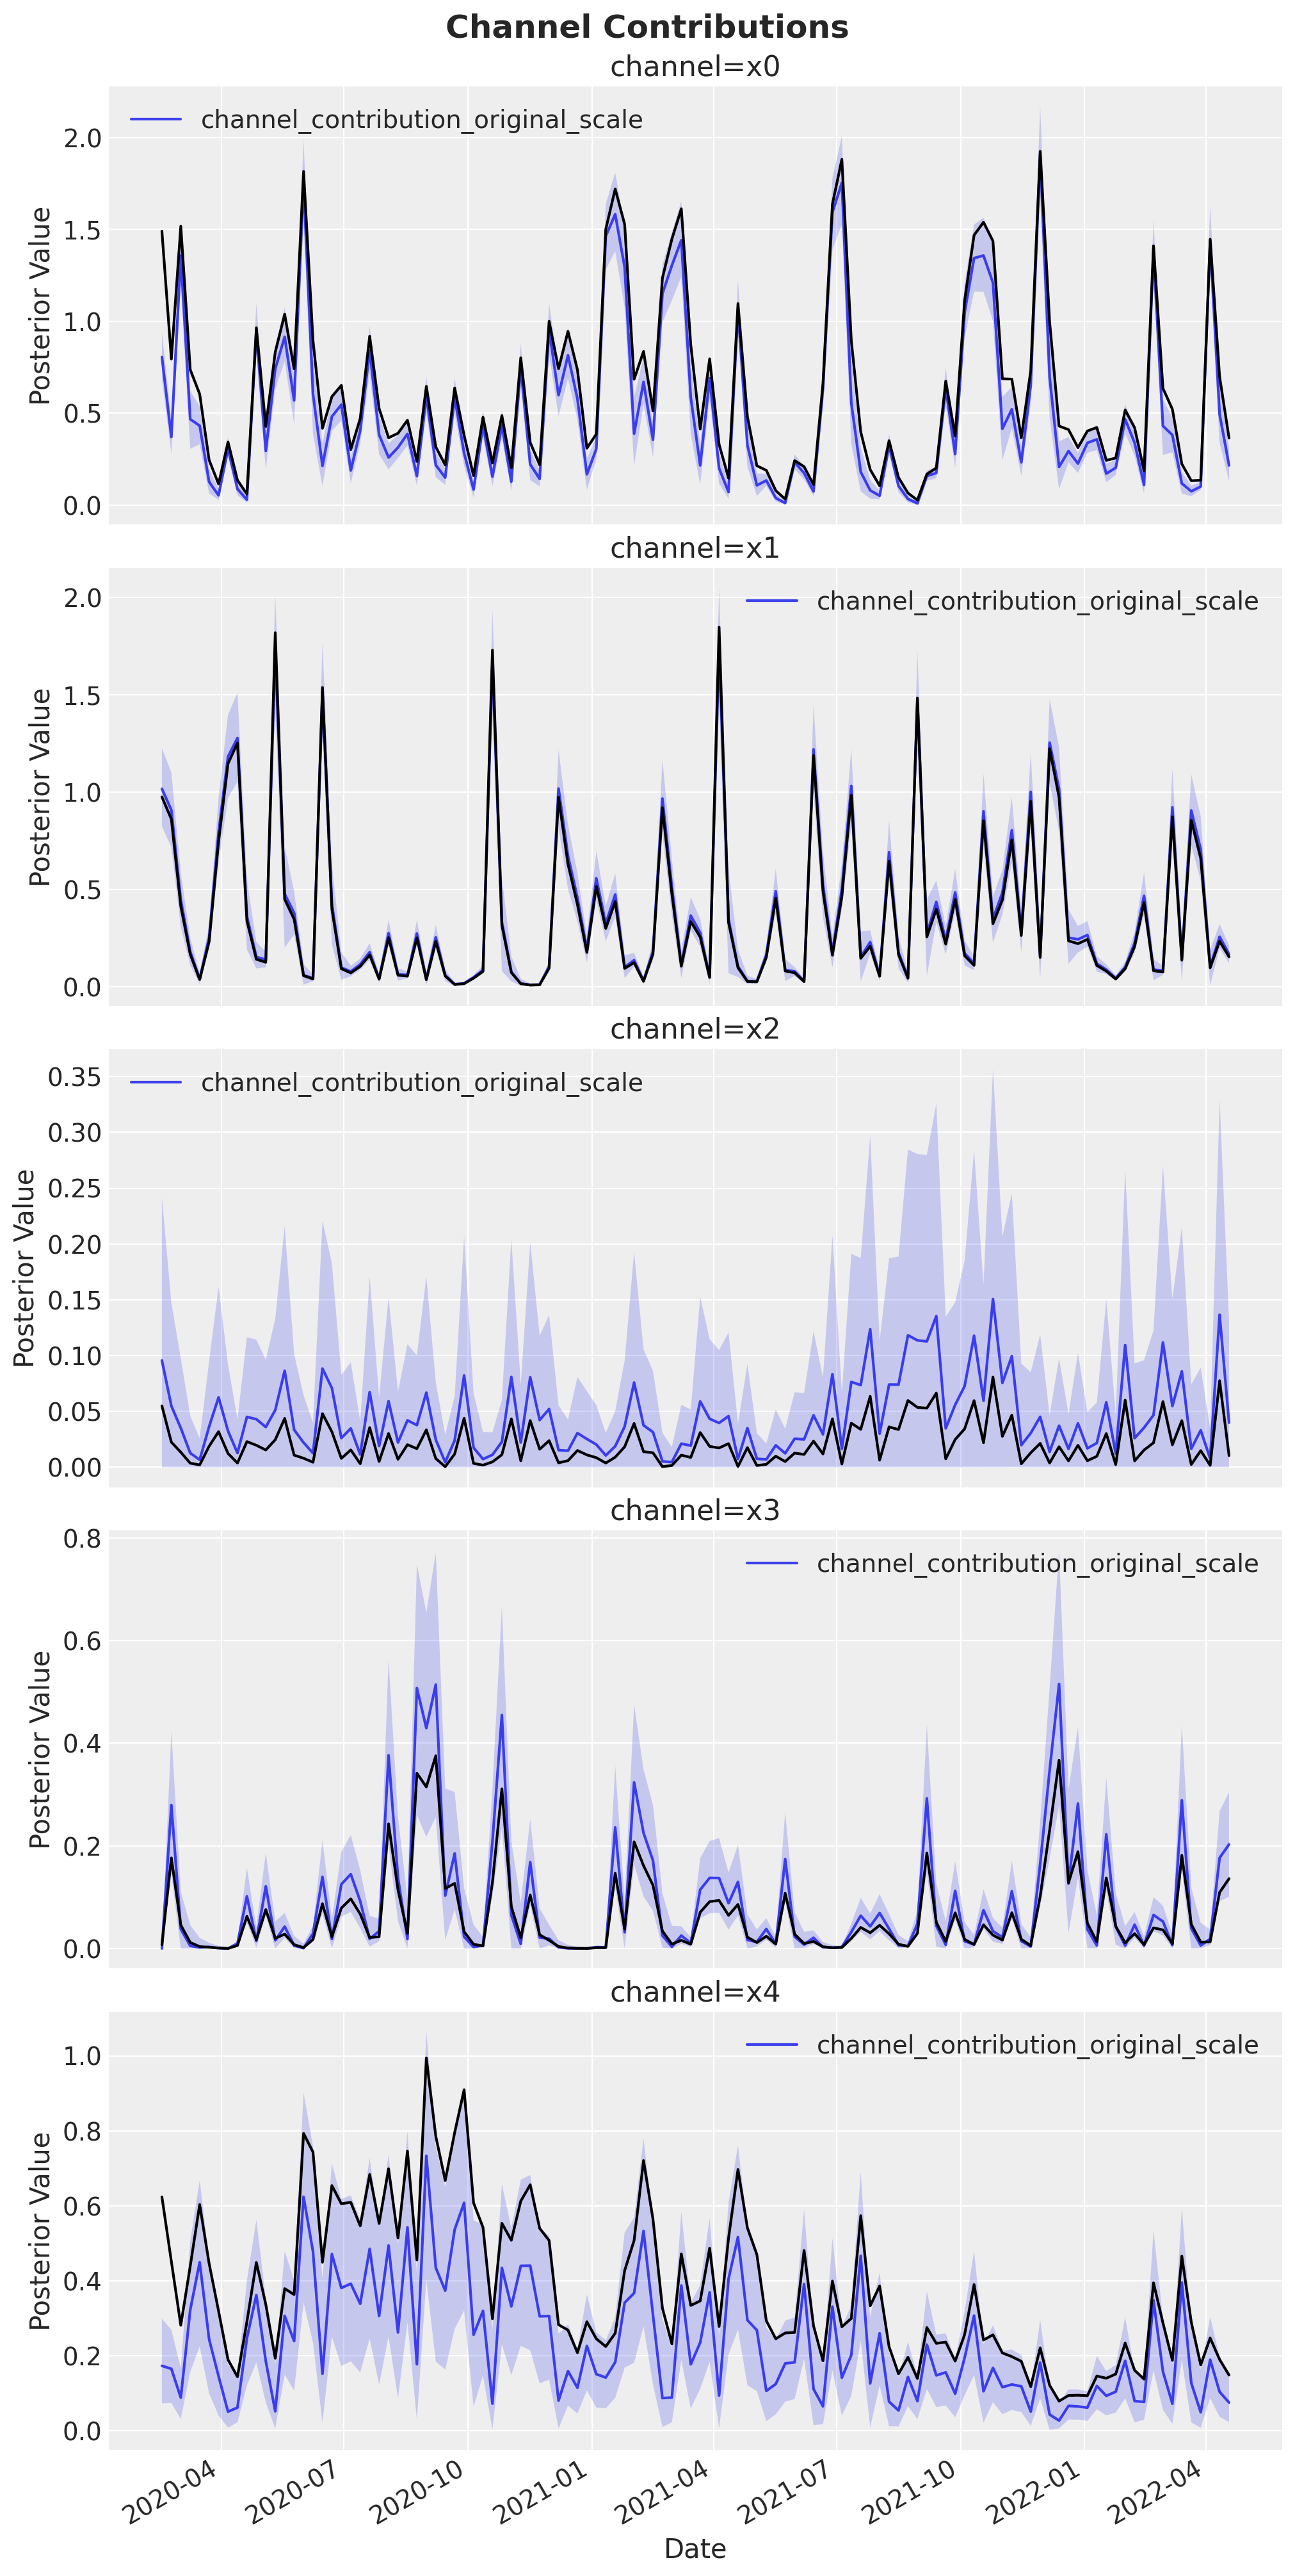

In [ ]:
fig, axes = mmm.plot.contributions_over_time(
    var=["channel_contribution_original_scale"], hdi_prob=0.94
)

axes = axes.flatten()

for i, channel in enumerate(coords["channel"]):
    channel_contribution_observed = (
        idata_obs["prior"]["channel_contribution_original_scale"]
        .sel(chain=0, draw=0)
        .sel(channel=channel)
        .to_numpy()[l_max:]
    )

    sns.lineplot(
        data=mmm_df,
        x="date",
        y=channel_contribution_observed,
        color="black",
        ax=axes[i],
    )

fig.autofmt_xdate()
fig.suptitle("Channel Contributions", fontsize=18, fontweight="bold");

In [ ]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Thu, 12 Feb 2026

Python implementation: CPython
Python version       : 3.13.12
IPython version      : 9.10.0

arviz         : 0.23.4
matplotlib    : 3.10.8
numpy         : 2.3.5
pandas        : 2.3.3
pymc          : 5.27.1
pymc_extras   : 0.8.0
pymc_marketing: 0.18.0
pytensor      : 2.37.0
seaborn       : 0.13.2

Watermark: 2.6.0

